In [1]:
import keras
import numpy as np
from scipy.io import loadmat
import h5py
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/home/maria/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/maria/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/maria/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/maria/anaconda3/lib/python3.7/site-packages/tensorflo

In [2]:
dat=loadmat('/media/maria/DATA1/Documents/ZebraFish/subject_3/data_full.mat')['data']
stim_dat=loadmat('/media/maria/DATA1/Documents/ZebraFish/subject_1/data_full.mat')['data']['stim_full'][0][0]

hf = h5py.File('/media/maria/DATA1/Documents/ZebraFish/subject_1/TimeSeries.h5', 'r')
neural_dat=np.array(hf['CellResp'])

In [3]:
print(neural_dat.shape)

(2880, 83205)


In [4]:
first_pop=neural_dat[:,:1000]
second_pop=neural_dat[:,1000:2000]

In [5]:
from sklearn.model_selection import train_test_split
#indices=range(75)
first_pop_train,first_pop_test,second_pop_train,second_pop_test=train_test_split(first_pop,second_pop,test_size=0.33, random_state=42)
print(first_pop_train.shape)
print(second_pop_train.shape)

(1929, 1000)
(1929, 1000)


In [8]:
from sklearn.decomposition import PCA
pca_first=PCA(n_components=5)
pca_second=PCA(n_components=10)

pcs_first=pca_first.fit_transform(first_pop_train)
pcs_second=pca_second.fit_transform(second_pop_train)

pcs_first_test=pca_first.transform(first_pop_test)
pcs_second_test=pca_second.transform(second_pop_test)


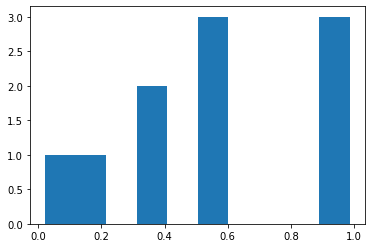

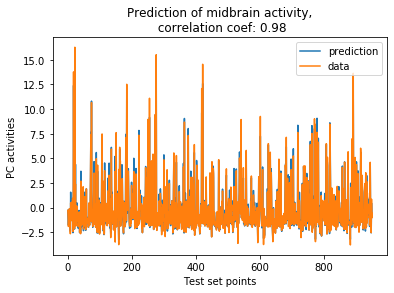

In [11]:
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
def ridge_regression(train_inputs,train_outputs,test_inputs,test_outputs,regularization_parameter=0.01):

    from_front_to_mid_reg=Ridge(regularization_parameter)

    from_front_to_mid_reg.fit(train_inputs,train_outputs)
    prediction=from_front_to_mid_reg.predict(test_inputs)

    pcs_corr=[]
    for j in range(0,test_outputs.shape[1]):
        #print(np.corrcoef(prediction[:,j],test_outputs[:,j])[0,1])
        pcs_corr.append(np.corrcoef(prediction[:,j],test_outputs[:,j])[0,1])

    plt.hist(pcs_corr)
    plt.show()

    ind_to_plot=np.argsort(pcs_corr)[-1]
    #ind_to_plot=2
    plt.plot(prediction[:,ind_to_plot],label='prediction')
    plt.plot(test_outputs[:,ind_to_plot],label='data')
    plt.title('Prediction of second activity,\n correlation coef: '+str(pcs_corr[ind_to_plot])[0:4])
    plt.xlabel('Test set points')
    plt.ylabel('PC activities')
    plt.legend()
    
    return from_front_to_mid_reg
    
from_front_to_mid_reg=ridge_regression(pcs_first,pcs_second,pcs_first_test,pcs_second_test)